In [1]:
from doctest import testfile

import numpy as np
import matplotlib.pyplot as plt

In [95]:
#Variables
BitsArray = [700,700,700, 700, 700, 700, 700]
bits_tx = np.random.randint(0,2, size=BitsArray[0])
SF = 7
SF_Validos = [7, 8, 9, 10, 11, 12]
M = 2**SF
simbolo_tx = coder(bits_tx, SF)
Decodificados = decoder(simbolo_tx, SF)
chirp_tx = waveform_former(simbolo_tx, SF)
chirp_tx_aux = waveform_former(simbolo_tx, SF)[0]
downchirp = (1 / np.sqrt(M)) * np.exp(-1j * 2 * np.pi * np.arange(M)**2 / M)
simbolo_rx = n_tuple_former(chirp_tx, SF)
s_rx = n_tuple_former(chirps_tx, SF)

## CODIFICADOR

In [96]:

def coder(bits, SF):
    #Verificar si SF es valido
    if SF not in SF_Validos:
        raise ValueError("Invalido")
    #Verificar que la cantidad de bits sea multiplo del SF
    if len(bits) % SF != 0:
        raise ValueError("Numero de bits no es multiplo de SF")

    # Inicialización del vector de símbolos
    N_simbolos = len(bits) // SF
    s = np.zeros(N_simbolos, dtype=int)

    # Implementación de la ecuación (1)
    for i in range(N_simbolos):
        for h in range(SF):
            s[i] += bits[i * SF + h] * (2 ** h)

    return s

print(simbolo_tx)

[ 41  50 103  25  11  34 104 113   8  85  45   3  43  92 114 110  64  62
  18 125  66  99  56 116 123 100  26  96  37 118  80  24 125  19 122  70
 119  34  18  49  32  59   0  11  70 108  61  86  64  60  38  25 103  58
  20  31  20   8 106  77   8  66  36 122  66 106 122   1  31  12   1  43
  44  68  30  48  28  67  88 126  43 127  11  98 109  89 104   1  64  23
  44 104  94 120  97  66  87  93 106  85]


###  Ejemplo de codificación usando la Ecuación (1)

#### Datos de entrada:

- bits = [1, 0, 0, 1, 1, 1, 0]
- SF = 7

#### Desarrollo paso a paso:

Agrupamos los 7 bits como un único símbolo, ya que SF = 7.

$\begin{aligned}
s &= w_0 \cdot 2^0 + w_1 \cdot 2^1 + w_2 \cdot 2^2 + w_3 \cdot 2^3 + w_4 \cdot 2^4 + w_5 \cdot 2^5 + w_6 \cdot 2^6 \\
  &= 1 \cdot 2^0 + 0 \cdot 2^1 + 0 \cdot 2^2 + 1 \cdot 2^3 + 1 \cdot 2^4 + 1 \cdot 2^5 + 0 \cdot 2^6 \\
  &= 1 \cdot 1 + 0 \cdot 2 + 0 \cdot 4 + 1 \cdot 8 + 1 \cdot 16 + 1 \cdot 32 + 0 \cdot 64 \\
  &= 1 + 0 + 0 + 8 + 16 + 32 + 0 \\
  &= 57
\end{aligned}$


####  Resultado esperado:
57


## DECODIFICADOR

In [97]:
def decoder(s, SF):
    if SF not in SF_Validos:
        raise ValueError("SF inválido")

    bits_recuperados = []

    # Por cada símbolo, reconstruir los SF bits
    for simbolo in s:
        for h in range(SF):
            bit = (simbolo >> h) & 1
            bits_recuperados.append(bit)

    return np.array(bits_recuperados, dtype=int)  # Convertir al final si querés array
print(Decodificados)

[1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1
 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1
 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1
 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0
 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1
 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1
 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0
 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0
 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1
 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0
 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1
 0 0 0 0 1 1 0 0 0 1 0 0 

### Decodificación manual del símbolo (Ecuación inversa de la codificación)

#### Dato recibido:

- Símbolo codificado: s = 57
- Spreading Factor: SF = 7

Queremos obtener los 7 bits originales que generaron este símbolo.


#### Desarrollo paso a paso:
$\begin{aligned}
c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi \cdot \left[ \frac{(s(nT_s) + k) \bmod 2^{SF} \cdot k}{2^{SF}} \right]}
\quad \text{para } k = 0, 1, \dots, 2^{SF}-1
\end{aligned}$


$ (57 >> 0) \& 1 = 57 \& 1 \newline$
                    $\begin{aligned} (57 >> 1) \& 1 = 28 \& 1 \end{aligned}$
                    $\begin{aligned} (57 >> 2) \& 1 = 14 \& 1 \end{aligned}$
                    $\begin{aligned} (57 >> 3) \& 1 = 7 \& 1 \end{aligned}$
                    $\begin{aligned} (57 >> 4) \& 1 = 3 \& 1 \end{aligned}$
                    $\begin{aligned} (57 >> 5) \& 1 = 1 \& 1 \end{aligned}$
                    $\begin{aligned} (57 >> 6) \& 1 = 0 \& 1 \end{aligned}$



In [98]:

def errores(lista1, lista2):

    error=0
    for i,j in zip(lista1, lista2):
        if (i != j):
            error+=1
    return error

def ber(bits_tx,bits_rx):
    BER=errores(bits_tx,bits_rx)/len(bit_randoms)
    return BER

print(ber(bits_tx,Decodificados))

0.0


### Waveformer Former

In [99]:

def waveform_former(s, SF):
    M = 2 ** SF  # cantidad de muestras por chirp
    chirps = []

    for simbolo in s:
        k = np.arange(M)
        fase = ((simbolo + k) % M) * k / M
        chirp = (1 / np.sqrt(M)) * np.exp(1j * 2 * np.pi * fase)
        chirps.append(chirp)

    return np.array(chirps)  # matriz [N x M]

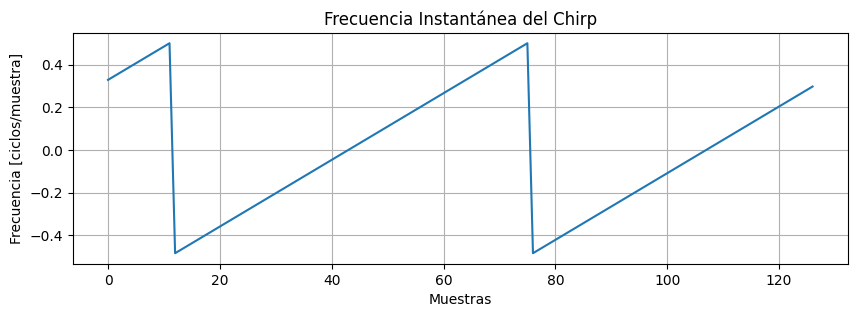

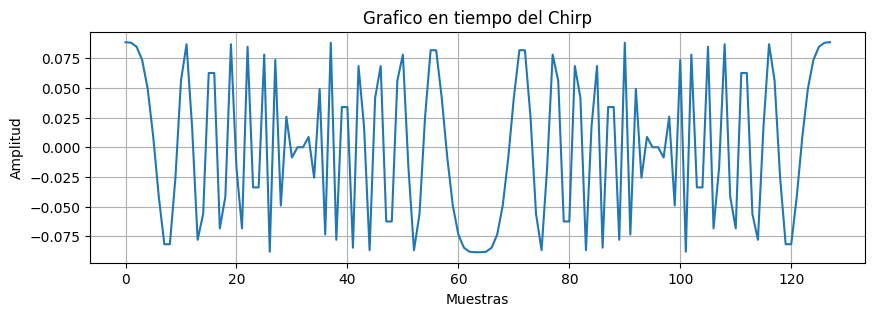

In [119]:
 # Generar un chirp
# Calcular fase y frecuencia instantánea
fase = np.unwrap(np.angle(chirp_tx_aux))
frecuencia_inst = np.diff(fase) / (2 * np.pi)

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(frecuencia_inst)
plt.title("Frecuencia Instantánea del Chirp")
plt.xlabel("Muestras")
plt.ylabel("Frecuencia [ciclos/muestra]")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(chirp[:2**SF])
plt.title("Grafico en tiempo del Chirp")
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

##  Waveform Former

###  Ecuación (2) del paper de Vangelista

La señal modulada transmitida para un símbolo $\begin{aligned}( s(nT_s) \in \{0, 1, \dots, 2^{SF} - 1\}) \end{aligned}$, según la Ecuación (2) del paper, se define como:



$\begin{aligned}
c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi \cdot \left[ \frac{(s(nT_s) + k) \bmod 2^{SF} \cdot k}{2^{SF}} \right]}
\quad \text{para } k = 0, 1, \dots, 2^{SF}-1
\end{aligned}$

Donde:
- $\begin{aligned} SF \end{aligned}$: Spreading Factor.
- $\begin{aligned} s(nT_s)\end{aligned}$: símbolo entero codificado (de 0 a \(2^{SF}-1\)).
- $\begin{aligned} k \end{aligned}$: índice de muestra temporal (discreto).
- $\begin{aligned} c(nT_s + kT) \end{aligned}$: muestra compleja de la forma de onda LoRa transmitida.

Esta señal es un "chirp" modulado en frecuencia, cuya frecuencia instantánea varía linealmente.




### n-Tuple Former

In [101]:
def n_tuple_former(received_chirps, SF):
    M = 2 ** SF
    k = np.arange(M)
    downchirp =  np.exp(-1j * 2 * np.pi * k**2 / M)

    simbolos_estimados = []
    for chirp in received_chirps:
        producto = chirp * downchirp
        fft_producto = np.fft.fft(producto) #Es la Transformada Rápida de Fourier (FFT) en NumPy
        simbolo_estimado = np.argmax(np.abs(fft_producto))
        simbolos_estimados.append(simbolo_estimado)

    return np.array(simbolos_estimados)


##  n-Tuple Former — Receptor Óptimo

###  Descripción Teórica (Sección III del paper de Vangelista)

La detección del símbolo transmitido se realiza aplicando un correlador discreto implementado como un receptor óptimo (n-Tuple Former). El procedimiento consiste en:

1. Multiplicar el chirp recibido por una señal conjugada de referencia conocida como "downchirp":
   $\begin{aligned}
   d(k) = e^{-j2\pi \cdot \frac{k^2}{2^{SF}}}
   \end{aligned}$
2. Aplicar una Transformada Rápida de Fourier (FFT) al producto.
3. Detectar el símbolo como el índice del valor máximo del espectro resultante.


###  Análisis Matemático

Para cada chirp recibido $\begin{aligned} r(k) \end{aligned}$, se realiza:

$\begin{aligned}
d(k) &= r(k) \cdot e^{-j2\pi \cdot \frac{k^2}{2^{SF}}} \\
R(f) &= \text{FFT}\left\{ d(k) \right\} \\
\hat{s} &= \arg \max_{f} \left| R(f) \right|
\end{aligned}$

Donde:
- $\begin{aligned} r(k) \end{aligned}$: chirp recibido de longitud $\begin{aligned} M = 2^{SF} \end{aligned}$
- $\begin{aligned} d(k) \end{aligned}$: señal desmodulada en base al downchirp
- $\begin{aligned} R(f) \end{aligned}$: transformada espectral
- $\begin{aligned} \hat{s} \end{aligned}$: símbolo estimado

Este proceso actúa como un **correlador en frecuencia**, donde cada símbolo posible produce un pico en una posición distinta del espectro. El símbolo transmitido es el que **mejor correlaciona** con el chirp recibido.



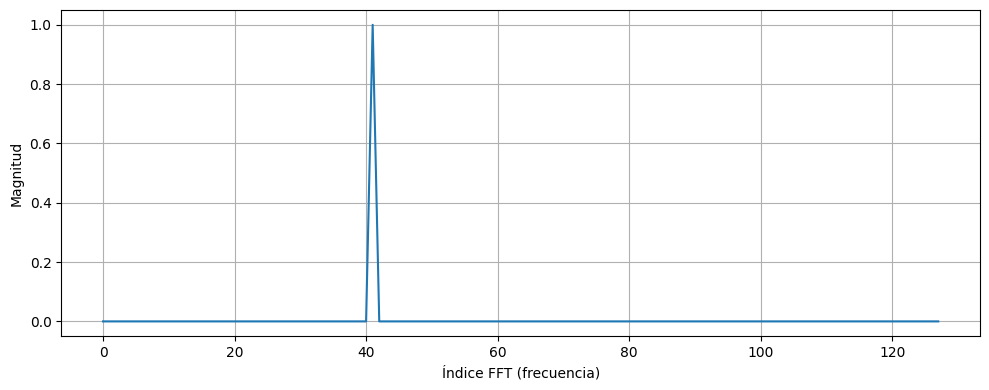

In [103]:
# Producto chirp con downchirp
produc = chirp_tx_aux * downchirp
fft_result = np.fft.fft(produc)
magnitud = np.abs(fft_result)

# Graficar la magnitud de la FFT
plt.figure(figsize=(10, 4))
plt.plot(magnitud)
plt.xlabel("Índice FFT (frecuencia)")
plt.ylabel("Magnitud")
plt.grid(True)
plt.tight_layout()
plt.show()

In [104]:
# Definimos funciones de utilidad
def errores_simbolos(s_tx, s_rx):
    #Cuenta cuántos símbolos difieren entre dos listas
    error = 0
    for i, j in zip(s_tx, s_rx):
        if i != j:
            error += 1
    return error

def ser(s_tx, s_rx):
    return np.mean(s_rx != s_tx)
    #return errores_simbolos(s_tx, s_rx) / len(s_tx)

In [105]:
# Transmisor

# Calcular SER
print("Símbolos transmitidos:", simbolo_tx)
print("Símbolos decodificados:", simbolo_rx)
print("SER:", ser(simbolo_tx, simbolo_rx))

Símbolos transmitidos: [ 41  50 103  25  11  34 104 113   8  85  45   3  43  92 114 110  64  62
  18 125  66  99  56 116 123 100  26  96  37 118  80  24 125  19 122  70
 119  34  18  49  32  59   0  11  70 108  61  86  64  60  38  25 103  58
  20  31  20   8 106  77   8  66  36 122  66 106 122   1  31  12   1  43
  44  68  30  48  28  67  88 126  43 127  11  98 109  89 104   1  64  23
  44 104  94 120  97  66  87  93 106  85]
Símbolos decodificados: [ 41  50 103  25  11  34 104 113   8  85  45   3  43  92 114 110  64  62
  18 125  66  99  56 116 123 100  26  96  37 118  80  24 125  19 122  70
 119  34  18  49  32  59   0  11  70 108  61  86  64  60  38  25 103  58
  20  31  20   8 106  77   8  66  36 122  66 106 122   1  31  12   1  43
  44  68  30  48  28  67  88 126  43 127  11  98 109  89 104   1  64  23
  44 104  94 120  97  66  87  93 106  85]
SER: 0.0


### Implementación del ruido AWGN

In [117]:
chirp_tx = waveform_former(simbolo_tx, SF)
def potenciaRuido(chirps):
     return np.mean(np.abs(chirps)**2)
print(potenciaRuido(chirp_tx))

0.007812499999999999


In [118]:
def agregar_ruido_AWGN_EbN0(chirps, SNR_dB, SF):
    # 1. Energía por símbolo (Es) es 1 para chirps normalizados.
    Es = 1.0

    # 2. Convertir Eb/N0 de dB a lineal.
    eb_n0_linear = 10**(SNR_dB / 10.0)

    # 3. Calcular Es/N0 a partir de Eb/N0, ya que Es = SF * Eb.
    #    SF (Spreading Factor) es el número de bits por símbolo.
    es_n0_linear = SF * eb_n0_linear

    # 4. Calcular la varianza del ruido (sigma^2), que es N0/2 por cada componente (real e imag).
    #    Para un sistema discreto, la varianza total del ruido complejo (sigma^2) es N0.
    #    sigma^2 = Es / (Es/N0)
    sigma2 = Es / es_n0_linear

    # 5. Generar el ruido con la varianza calculada.
    #    La desviación estándar para cada componente es sqrt(sigma2 / 2).
    ruido = np.sqrt(sigma2 / 2.0) * (np.random.randn(*chirps.shape) + 1j * np.random.randn(*chirps.shape))

    return chirps + ruido

##  Canal con Ruido AWGN y Curva BER/SER

### AWGN (Additive White Gaussian Noise)
Según la Sección IV del paper, el sistema puede ser evaluado bajo un modelo de canal con ruido aditivo blanco gaussiano complejo (AWGN).
Es un modelo de canal donde el ruido se suma a la señal transmitida:
- Media: 0
- Varianza: $\begin{aligned} \sigma^2 = \frac{E_s}{2 \cdot \text{SNR}_{\text{linear}}}\end{aligned}$


Donde:

$\begin{aligned}
\text{SNR}_{\text{linear}} = 10^{\frac{\text{SNR}_{dB}}{10}}, \quad
\sigma^2 = \frac{E_s}{2 \cdot \text{SNR}_{\text{linear}}}
\end{aligned}$



### Procedimiento:
1. Se genera una señal chirp (modulada) por símbolo.
2. Se suma ruido Gaussiano complejo a la señal transmitida.
3. Se decodifica usando n-Tuple Former + FFT.
4. Se comparan los símbolos y bits originales con los decodificados.
5. Se calcula y grafica:
   - BER: tasa de error de bit.
   - SER: tasa de error de símbolo.

In [126]:
def canal_selectivo_frecuencia(chirps, SF):
    """
    Aplica un canal selectivo en frecuencia a una secuencia de chirps.
    La respuesta del canal tiene un retardo de M muestras (1 símbolo).
    """
    M = 2 ** SF
    # Coeficientes del canal según el paper de Vangelista
    h = np.zeros(M + 1, dtype=complex)
    h[0] = np.sqrt(0.8)
    h[M] = np.sqrt(0.2)

    # Aplanar la matriz de chirps a un solo vector para la convolución
    signal_completa = chirps.flatten()

    # Aplicar el canal mediante convolución
    signal_filtrada = np.convolve(signal_completa, h, mode='full')

    # Reconstruir la matriz de chirps a partir de la señal filtrada
    num_chirps = chirps.shape[0]
    # Se toma solo la parte de la señal filtrada que corresponde a la longitud original
    chirps_out = np.reshape(signal_filtrada[:num_chirps * M], (num_chirps, M))

    return chirps_out

## Canal Selectivo en Frecuencia


En la Sección IV del paper de Vangelista, se modela un canal selectivo en frecuencia mediante una respuesta al impulso discreta definida como:

$\begin{aligned}
h(nT) = \sqrt{0.85} \cdot \delta(nT) + \sqrt{0.2} \cdot \delta(nT - T)
\end{aligned}$

Este canal tiene dos trayectorias:

- Una trayectoria directa con ganancia $\begin{aligned} \sqrt{0.85} \end{aligned}$ y sin retardo.
- Una trayectoria secundaria con ganancia $\begin{aligned} \sqrt{0.2} \end{aligned}$ y un retardo de $\begin{aligned} T \end{aligned}$, es decir, de una duración completa de chirp.

Dado que cada chirp tiene $\begin{aligned} M = 2^{\text{SF}} \end{aligned}$ muestras, se implementa el canal como una convolución discreta entre la señal transmitida y un vector $\begin{aligned} h \end{aligned}$ con dos picos:

$\begin{aligned}
h[n] =
\begin{cases}
\sqrt{0.85}, & n = 0 \\
\sqrt{0.2}, & n = M \\
0, & \text{en otro caso}
\end{cases}
\end{aligned}$

La función canal_selectivo_frecuencia(chirps, SF) realiza lo siguiente:

1. Construye la respuesta impulsiva del canal $\begin{aligned} h[n] \end{aligned}$ como un vector complejo de longitud $\begin{aligned} 2M \end{aligned}$, colocando los valores no nulos en las posiciones $\begin{aligned} 0 \end{aligned}$ y $\begin{aligned} M \end{aligned}$.

2. Concatena los chirps (que originalmente están separados en una matriz) en un único vector 1D con `flatten()`, para simular la transmisión continua por el canal.

3. Aplica la convolución de la señal concatenada con $\begin{aligned} h[n] \), lo que introduce interferencia entre chirps consecutivos debido al retardo.

4. Re-ensambla los chirps desde la señal filtrada, ignorando el primer chirp porque está contaminado por el retardo de la trayectoria secundaria.

5. Devuelve la salida a partir del segundo chirp, ya que es el primero no afectado por el retardo de otro símbolo anterior.

Este modelo permite simular los efectos de dispersión temporal (ISI) característicos de un canal selectivo en frecuencia, y es fundamental para reproducir la curva etiquetada como "Freq. Sel. FSCM" en la Figura 4 del paper de referencia.


Iniciando simulación para canal selectivo en frecuencia...
SNR: -15 dB -> BER: 0.497414, SER: 0.986039
SNR: -14 dB -> BER: 0.494957, SER: 0.981639
SNR: -13 dB -> BER: 0.494185, SER: 0.979479
SNR: -12 dB -> BER: 0.491631, SER: 0.978239
SNR: -11 dB -> BER: 0.490271, SER: 0.973159
SNR: -10 dB -> BER: 0.486974, SER: 0.966559
SNR: -9 dB -> BER: 0.483494, SER: 0.958078
SNR: -8 dB -> BER: 0.475476, SER: 0.944918
SNR: -7 dB -> BER: 0.468784, SER: 0.925637
SNR: -6 dB -> BER: 0.454270, SER: 0.901836
Simulación de canal selectivo finalizada.


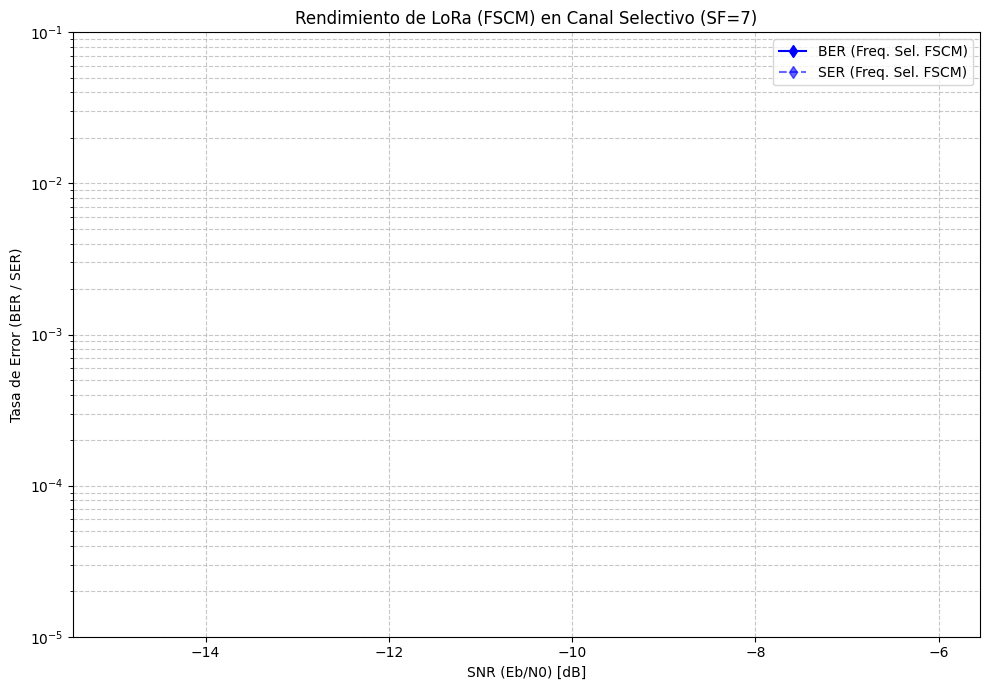

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# ===================================================================
# 1. FUNCIONES AUXILIARES (Canal, Ruido, BER y SER)
# ===================================================================

def canal_selectivo_frecuencia(chirps, SF):
    """
    Aplica un canal selectivo en frecuencia a una secuencia de chirps.
    La respuesta del canal tiene un retardo de M muestras (1 símbolo).
    """
    M = 2 ** SF
    # Coeficientes del canal según el paper de Vangelista
    h = np.zeros(M + 1, dtype=complex)
    h[0] = np.sqrt(0.8)
    h[M] = np.sqrt(0.2)

    # Aplanar la matriz de chirps a un solo vector para la convolución
    signal_completa = chirps.flatten()

    # Aplicar el canal mediante convolución
    signal_filtrada = np.convolve(signal_completa, h, mode='full')

    # Reconstruir la matriz de chirps a partir de la señal filtrada
    num_chirps = chirps.shape[0]
    # Se toma solo la parte de la señal filtrada que corresponde a la longitud original
    chirps_out = np.reshape(signal_filtrada[:num_chirps * M], (num_chirps, M))

    return chirps_out

def agregar_ruido_AWGN_EbN0(chirps, SNR_dB, SF):
    """Agrega ruido AWGN a los chirps basándose en una relación Eb/N0."""
    Es = 1.0  # Energía por símbolo es 1 para chirps normalizados
    eb_n0_linear = 10**(SNR_dB / 10.0)
    es_n0_linear = SF * eb_n0_linear
    sigma2 = Es / es_n0_linear
    ruido = np.sqrt(sigma2 / 2.0) * (np.random.randn(*chirps.shape) + 1j * np.random.randn(*chirps.shape))
    return chirps + ruido

def ber(bits_tx, bits_rx):
    """Calcula la Tasa de Error de Bit (Bit Error Rate)."""
    return np.mean(bits_tx != bits_rx)

def ser(s_tx, s_rx):
    """Calcula la Tasa de Error de Símbolo (Symbol Error Rate)."""
    return np.mean(s_tx != s_rx)

# ===================================================================
# 2. PARÁMETROS DE SIMULACIÓN
# ===================================================================

SF = 7
M = 2**SF
N_SIMBOLOS = 25000  # Se requiere un número alto para medir bajos BER
# En la sección de PARÁMETROS DE SIMULACIÓN, cambia esta línea:
# SNR_dBs = np.arange(-12, -1, 1)  # Línea original

# Cámbiala por esta para forzar más errores:
SNR_dBs = np.arange(-15, -5, 1)   # Nuevo rango sugerido  # Rango de SNR para la curva Freq.Sel.FSCM

# Generación de bits y símbolos aleatorios
bit_randoms = np.random.randint(0, 2, size=SF * N_SIMBOLOS)
s_tx = coder(bit_randoms, SF)
chirps_tx = waveform_former(s_tx, SF)

# ===================================================================
# 3. SIMULACIÓN PARA CANAL SELECTIVO EN FRECUENCIA
# ===================================================================
print("Iniciando simulación para canal selectivo en frecuencia...")
BERs_freq_sel, SERs_freq_sel = [], []

# Crear señal con intervalos de guarda (un chirp de ceros entre cada chirp de señal) para evitar ISI
chirps_con_guarda = np.zeros((2 * N_SIMBOLOS, M), dtype=complex)
chirps_con_guarda[::2] = chirps_tx  # Chirps de señal en posiciones pares

# Pasar la señal con guardas a través del canal selectivo
chirps_filtrados = canal_selectivo_frecuencia(chirps_con_guarda, SF)

# Extraer solo los chirps que originalmente contenían señal (posiciones pares)
# Estos chirps ahora están atenuados por el canal pero libres de ISI.
chirps_utiles = chirps_filtrados[::2]

# Descartar el primer chirp útil, que puede estar afectado por efectos de borde de la convolución
chirps_finales_canal = chirps_utiles[1:]
# Símbolos y bits de referencia correspondientes
s_tx_util = s_tx[1:]
bits_tx_util = bit_randoms[SF:]

for SNR in SNR_dBs:
    # Agregar ruido a los chirps ya afectados por el canal
    chirps_noisy = agregar_ruido_AWGN_EbN0(chirps_finales_canal, SNR, SF)

    # Decodificación
    s_rx = n_tuple_former(chirps_noisy, SF)
    bits_rx = decoder(s_rx, SF)

    # Cálculo de errores
    BERs_freq_sel.append(ber(bits_tx_util, bits_rx))
    SERs_freq_sel.append(ser(s_tx_util, s_rx))
    print(f"SNR: {SNR} dB -> BER: {ber(bits_tx_util, bits_rx):.6f}, SER: {ser(s_tx_util, s_rx):.6f}")

print("Simulación de canal selectivo finalizada.")

# ===================================================================
# 4. GRÁFICO DE RESULTADOS
# ===================================================================
limite_inferior_plot = 1e-6
BERs_plot = [b if b > 0 else limite_inferior_plot for b in BERs_freq_sel]
SERs_plot = [s if s > 0 else limite_inferior_plot for s in SERs_freq_sel]

plt.figure(figsize=(10, 7))
plt.semilogy(SNR_dBs, BERs_plot, 'd-', color='blue', label='BER (Freq. Sel. FSCM)')
plt.semilogy(SNR_dBs, SERs_plot, 'd--', color='blue', alpha=0.6, label='SER (Freq. Sel. FSCM)')
plt.ylim(1e-5, 1e-1)
plt.xlabel("SNR (Eb/N0) [dB]")
plt.ylabel("Tasa de Error (BER / SER)")
plt.title(f"Rendimiento de LoRa (FSCM) en Canal Selectivo (SF={SF})")
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()